## 0. Import all the libraries

In [1]:
import numpy as np
import numpy.linalg as la
import nltk
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
import string
import tqdm
import numba
import matplotlib.pyplot as plt
import scipy.spatial.distance as dist
import spacy
import sklearn
from sklearn.metrics.pairwise import cosine_similarity
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /home/leonid/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/leonid/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/leonid/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

## 1. DATA PREPARATION

### 1.1 Datasets loading
USE_TRAIN is used to "train" our graph on some adiitional data.
We print first 10 pairs to give you an example.

In [2]:
USE_TRAIN = True
DAT_FILE = 'dist_graph.dat'
with open('input.txt') as f:
    lines_test = [line.strip() for line in f]
with open('movies_text.txt') as f:
    lines_train = [line.strip() for line in f]

print(len(lines_test))
#lines_train = lines_train[:30]
#print(lines_movies[:10])

250


### 1.2 Preprocessing : remove punctuation, stopwords and lemmatize
We will work with sentences without punctuation marks. We also remove stopwords and lemmatize all the words.

In [3]:
stopwords_en = stopwords.words('english')
translation_table = str.maketrans('', '', string.punctuation)
lemmatizer = WordNetLemmatizer()
lemmas = set(wordnet.all_lemma_names())

words = dict()
test_words = dict()
sentences_test = list()

for line in lines_test:
    s1, s2 = line.split('\t')

    v1 = []
    v2 = []

    for s, v in [(s1, v1), (s2, v2)]:
        for w in s.split():
            w = w.lower().translate(translation_table)
            if w in stopwords_en:
                continue
            w = lemmatizer.lemmatize(w)
            if w not in lemmas:
                continue
            words.setdefault(w, len(words))
            test_words.setdefault(w, len(test_words))
            v.append(words[w])

    sentences_test.append((v1, v2))

sentences_train = list()
if USE_TRAIN:
    for s in lines_train:
        #s1, s2 = line.split('\t')
        
        v = []
        

        for w in s.split():
            w = w.lower().translate(translation_table)
            if w in stopwords_en:
                continue
            w = lemmatizer.lemmatize(w)
            if w not in lemmas:
                continue
            
            words.setdefault(w, len(words))
            v.append(words[w])

        sentences_train.append(v)
    


In [4]:
print(len(words.keys()))
print(len(test_words.keys()))


18669
687


## 2. Main Algorithm

### 2.1 Make synonyms graph
First, we create a graph representing synonyms. For that, we use **wordnet** synonyms.

In **synonym_graph**, synonym_graph[i][j] is 1, iff the word words[i] and the word words[j] are synonyms.

In [5]:
synonym_graph = np.zeros((len(words), len(words)))

def set_of_synonyms(word):
    synonyms = []
    for syn in wordnet.synsets(word):
        for l in syn.lemmas():
            syn_word = l.name()
            if syn_word in stopwords_en:
                continue
            syn_word = lemmatizer.lemmatize(syn_word)
            synonyms.append(syn_word)
    return set(synonyms)

for word, idx in words.items():
    for syn in set_of_synonyms(word):
        if syn not in words:
            continue
        syn_idx = words[syn]
        synonym_graph[idx][syn_idx] = 1
        synonym_graph[syn_idx][idx] = 1
if USE_TRAIN:
    synonym_graph = synonym_graph[:len(test_words), :len(test_words)]


We give you an example of a set of synonyms for the first word in the dictionary.

We see that there are 3 synonyms for "person" in the corpus.

In [6]:
print(list(words.keys())[0])
print(set_of_synonyms(list(words.keys())[0]))
print(sum(synonym_graph[0]))

person
{'individual', 'somebody', 'someone', 'mortal', 'person', 'soul'}
3.0


### 2.2 Make sliding window graph
Now, we create a sliding window graph.

**window_size** is a parameter. Each time two words words[i] and words[j] are in sliding window, we add 1 to window_graph[i][j].

In [7]:
window_size = 3

window_graph_train = np.zeros((len(words), len(words)))

for ss in sentences_test:
    for s in ss:
        window = []
        for i in range(len(s)):
            window = window[-(window_size - 1):]
            v1 = s[i]
            for v2 in window:
                window_graph_train[v1][v2] += 1
                window_graph_train[v2][v1] += 1
            window.append(v1)
if USE_TRAIN:
    for s in sentences_train:
        window = []
        for i in range(len(s)):
            window = window[-(window_size - 1):]
            v1 = s[i]
            for v2 in window:
                window_graph_train[v1][v2] += 1
                window_graph_train[v2][v1] += 1
            window.append(v1)
if USE_TRAIN:
    window_graph = window_graph_train[:len(test_words), :len(test_words)]
else:
    window_graph = window_graph_train

In [8]:
print(window_graph.shape)

(687, 687)


### 2.3 Make Spacy dependency tree graph

Here we create a graph representing sentence syntactic.

We work with **spaCy** dependency trees. **spaCy** uses the terms head and child to describe the words connected by a single arc in the dependency tree. Because the syntactic relations form a tree, every word has exactly one head. We can therefore iterate over the arcs in the tree by iterating over the words in the sentence.

In [9]:
dependency_graph = np.zeros((len(test_words), len(test_words)))
translation_table = str.maketrans('', '', string.punctuation)

nlp = spacy.load("en_core_web_lg")

for i in range(len(lines_test)):
    sent1, sent2 = lines_test[i].split('\t')
    sent1 = ' '.join([w for w in sent1.split()])
    sent2 = ' '.join([w for w in sent2.split()])
    sent1 = nlp(sent1)
    sent2 = nlp(sent2)

    for s in [sent1, sent2]:
        for w in s: #iteration over the words in the sentence
            w1 = w.text.lower().translate(translation_table)
            w2 = w.head.text.lower().translate(translation_table)

            if (not w1 in stopwords_en) & (not w2 in stopwords_en) & (w.dep_ != "ROOT") & (w.dep_ != "punct"):
                w1 = lemmatizer.lemmatize(w1)
                w2 = lemmatizer.lemmatize(w2)
                if (w1 in test_words) & (w2 in test_words):
                    dependency_graph[test_words[w1]][test_words[w2]] += 1
                    dependency_graph[test_words[w2]][test_words[w2]] += 1

We show you the number of words in syntactic dependacies with "person" in the corpus.

In [10]:
print(sum(dependency_graph[0]))

19.0


### 2.4 Combine synonym, window graphs and dependency graph

Now, in order to use the information on synonyms, word order in sentences and syntactic dependencies, we put 3 graps together.

Then we complete distance matrix with shortest path lengths.

In [11]:
print(synonym_graph.shape, window_graph.shape, dependency_graph.shape)
distances = 1 / (synonym_graph + window_graph + dependency_graph + 1)
#gr_max = np.max(synonym_graph + window_graph + dependency_graph)
#distances = gr_max - (synonym_graph + window_graph + dependency_graph) + 1
for i in range(distances.shape[0]):
    for j in range(distances.shape[0]):
        if distances[i][j] == 1:
            distances[i][j] = -1.0

np.fill_diagonal(distances, 0)

def floyd_warshall(dist):
    n = dist.shape[0]
    for u in tqdm.trange(n):
        for v in range(n):
            if dist[u][v] == -1.0:
                dist[u][v] = 10e6

    @numba.jit
    def h(dist, n, z):
        for u in range(n):
            for v in range(n):
                if (dist[u][v] > dist[u][z] + dist[z][v]):
                    dist[u][v] = dist[u][z] + dist[z][v]

    for z in tqdm.trange(n):
        h(dist, n, z)
        
    
floyd_warshall(distances)

if np.max(distances) == 10e6:
    print("Distances graph is not connected")
else:
    print("Distances graph is connected")

(687, 687) (687, 687) (687, 687)


100%|██████████| 687/687 [00:00<00:00, 1683.24it/s]

Distances graph is connected


### 2.5 Distance Geometry

In this part we produce an approximate realisation of $x$.

We have an approximate EDMs $\tilde{D}$ from raw data. Then we compute an approximate Gram matrix:

$$ \tilde{G} = - \frac{1}{2} J \tilde{D}^2 J, $$

where $J = I_n - \frac{1}{n}\mathbb{1}\mathbb{1}^{T}$.

Having spectral decomposition of $\tilde{G} = P \tilde{\Lambda} P^{T}$, we find $\Lambda$ the PSD diagonal matrix closest to $\tilde{\Lambda}$.

$\Lambda$ is obtained from $\tilde{\Lambda}$ by zeroing negative components.

So, finally, $x = P \sqrt{\Lambda}$.

To move $x$ to $0$, we reduce it by its mean. 

In [12]:
@numba.jit
def mds(matD, k):
    N = matD.shape[0]
    matJ = np.eye(N) - np.ones((N, N)) / N
    matG = -0.5 * matJ @ (matD ** 2) @ matJ
    vecL, matP = la.eigh(matG)
    vecL[vecL < 0] = 0
    return matP[:,-k:], vecL[-k:]

def embed_graph(distances, k):
    p, l = mds(distances, k)
    result = p @ np.diag(np.sqrt(l))
    result -= np.mean(result, axis=0)
    return result

In [13]:
import sys

with open('dist_graph.dat', 'w') as f:
    #sys.stdout = f # Change the standard output to the file we created.
    f.write("param Kdim := 3;\nparam n := {};\nparam : E : c I :=\n".format(distances.shape[0]))
    for i in tqdm.trange(distances.shape[0]):
        for j in range(distances.shape[0]):
            if i-j==0:
                continue
            f.write("{} {} {} 1\n".format(i+1, j+1, distances[i, j]))
    f.write(";")
    f.close()

100%|██████████| 687/687 [00:00<00:00, 952.79it/s]


In [14]:
from amplpy import AMPL
import numpy as np
lp = AMPL()
lp.read("dgp1.mod")
lp.readData("dist_graph.dat")
lp.setOption("solver", "baron")
lp.setOption("baron_options", "outlev=1 epsr=1e-3 prfreq=1e3 maxtime=30")
lp.solve()
ndata = lp.getData("n")
n = int(ndata.getRowByIndex(0)[0])
solveres = lp.getData("solve_result")
solve_result = solveres.getRowByIndex(0)[0]
objfun = lp.getObjective("objfun")
objfunval = objfun.value()
xvar = lp.getVariable("x")
x = np.zeros(n)
for j in range(n):
    x[j] = xvar[j+1].value()

*******************************************************************************
* Please make sure that the AMPL folder is in the system search path, or      *
* specify the path via:                                                       *
*     AMPL(Environment('full path to the AMPL installation directory'))       *
*******************************************************************************


RuntimeError: AMPL could not be started. Message from process thread:
cannot execute ampl: No such file or directory



### 3.1 Visualisation in 2D 

Next plot gives us a visualisation of the result on 2D. Then we will use k = 20 dimensions.

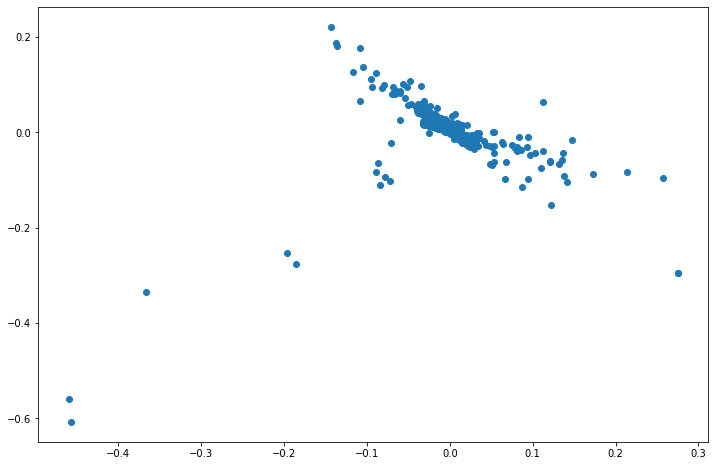

In [ ]:
k=20
word_to_vec = embed_graph(distances, k)

plt.figure(figsize=(12,8))
plt.scatter(*embed_graph(distances, 2).transpose())
plt.show()

In [15]:
import sys
import os.path
from amplpy import AMPL
import cvxpy as cp
import cvxopt
import time
import math
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import dgp_sdp

In [30]:
def sdp(DAT_FILE, showplot=False):
    (Kdim, n, E) = dgp_sdp.readDat('./' + DAT_FILE)

    ## construct weighted vertex neighbourhoods from edges
    G = {i:dict() for i in range(n)}
    for e in E:
        i = e[0]-1 # first vertex
        j = e[1]-1 # second vertex
        w = e[2] # edge weight
        if i > j:
            t = i
            i = j
            j = t
        G[i][j] = w 

    ## MP formulation: vars, obj, constrs
    X = cp.Variable((n,n), PSD=True)

    cobj1 = sum([X[i,i] + X[j,j] - 2*X[i,j] for i in range(n) for j in G[i] if i<j])
    objective = cp.Minimize(cobj1)

    constraints = [X[i,i] + X[j,j] - 2*X[i,j] == G[i][j]**2 for i in range(n) for j in G[i] if i<j]
    prob = cp.Problem(objective, constraints)

    ## solve the problem
    prob.solve(solver=cp.SCS, verbose=True)

    objfunval = prob.value
    print("optimal obj. fun. value =", objfunval)

    ## retrieve realization in K dimensions
    print("ambient dimension n =", n)
    Y = dgp_sdp.MDS(X.value)
    K = Y.shape[1]
    print("found relaxed embedding in natural dimension K =", K)
    if K not in {2,3}:
        if K < 2:
            K = 2
        elif K > 3:
            K = 3
    print("now projecting to", K, "principal dimensions")
    xbar = dgp_sdp.PCA(X.value, K)
        
    ## report SDP solution statistics
    mderr1 = dgp_sdp.mde(xbar, G)
    print("SDP mean distance error =", mderr1)
    lderr1 = dgp_sdp.lde(xbar, G)
    print("SDP largest distance error =", lderr1)

    from amplpy import Environment

    ## refine solution with a local NLP solver
    nlp = AMPL(Environment('../ampl'))
    nlp.read("dgp.mod")
    nlp.readData('./' + DAT_FILE)
    nlp.setOption('solver', dgp_sdp.NLPsolver)
    xvar = nlp.getVariable('x')
    for i in range(n):
        for k in range(K):
            xvar[i+1,k+1].setValue(xbar[i,k])
    nlp.solve()
    xvar = nlp.getVariable('x')
    xval = xvar.getValues()
    x = np.zeros((n,K))
    for i in range(n):
        for k in range(K):
            x[i,k] = xvar[i+1,k+1].value()

    # report NLP solution statistics
    mderr2 = dgp_sdp.mde(x, G)
    print("NLP mean distance error =", mderr2)
    lderr2 = dgp_sdp.lde(x, G)
    print("NLP largest distance error =", lderr2)

    # report total statistics

    print("OUTLABELS:mp,projmethod,objX,mdeX,ldeX,mdex,ldex")
    print("OUT:sdp,{0:s},{1:.3f},{2:.3f},{3:.3f},{4:.3f},{5:.3f}".format(dgp_sdp.projmethod,objfunval, mderr1, lderr1, mderr2, lderr2))

    ## plot results
    if dgp_sdp.showplot:
        if K == 2:
            plt.scatter(x[:,0], x[:,1])
            plt.plot(x[:,0], x[:,1])
        elif K == 3:
            fig = plt.figure()
            ax = Axes3D(fig)
            ax.scatter(x[:,0], x[:,1], x[:,2])
            ax.plot(x[:,0], x[:,1], x[:,2])
            ax.set_xlabel('x')
            ax.set_ylabel('y')
            ax.set_zlabel('z')    
        plt.show()

In [40]:
def ddp(DAT_FILE, showplot=False):
    # read instance
    (Kdim, n, E) = dgp_sdp.readDat('./' + DAT_FILE)

    # see if we need to plot
    if len(sys.argv) >= 3:
        if sys.argv[2] == "noplot":
            showplot = False

    ## construct weighted vertex neighbourhoods from edges
    G = {i:dict() for i in range(n)}
    for e in E:
        i = e[0]-1 # first vertex
        j = e[1]-1 # second vertex
        w = e[2] # edge weight
        if i > j:
            t = i
            i = j
            j = t
        G[i][j] = w 

    ## formulate and solve the dual DDP
    ddp = AMPL(Environment('../ampl'))
    ddp.read("dgp_ddp.mod")
    ddp.readData('./' + DAT_FILE)
    ddp.setOption('solver', dgp_sdp.LPsolver)
    ddp.solve()
    objfun = ddp.getObjective('push')
    objfunval = objfun.value()
    print("optimal obj. fun. value =", objfunval)
    Xvar = ddp.getVariable('X')
    X = np.zeros((n,n))
    for i in range(n):
        for j in range(n):
            X[i,j] = Xvar[i+1,j+1].value()

    ## retrieve realization in K dimensions
    print("ambient dimension n =", n)
    Y = dgp_sdp.MDS(X)
    K = Y.shape[1]
    print("found relaxed embedding in natural dimension K =", K)
    if K not in {2,3}:
        if K < 2:
            K = 2
        elif K > 3:
            K = 3
    print("now projecting to", K, "principal dimensions")
    xbar = dgp_sdp.PCA(X, K)

    ## report dualDDP solution statistics
    mderr1 = dgp_sdp.mde(xbar, G)
    print("DDP mean distance error =", mderr1)
    lderr1 = dgp_sdp.lde(xbar, G)
    print("DDP largest distance error =", lderr1)

    ## refine solution with a local NLP solver
    nlp = AMPL(Environment('../ampl'))
    nlp.read("dgp.mod")
    nlp.readData('./' + DAT_FILE)
    nlp.setOption('solver', dgp_sdp.NLPsolver)
    xvar = nlp.getVariable('x')
    for i in range(n):
        for k in range(K):
            xvar[i+1,k+1].setValue(xbar[i,k])
    nlp.solve()
    xvar = nlp.getVariable('x')
    xval = xvar.getValues()
    x = np.zeros((n,K))
    for i in range(n):
        for k in range(K):
            x[i,k] = xvar[i+1,k+1].value()

    # report NLP solution statistics
    mderr2 = dgp_sdp.mde(x, G)
    print("NLP mean distance error =", mderr2)
    lderr2 = dgp_sdp.lde(x, G)
    print("NLP largest distance error =", lderr2)

    # report total statistics
    print("OUTLABELS:mp,projmethod,objX,mdeX,ldeX,mdex,ldex")
    print("OUT:sdp,{0:s},{1:.3f},{2:.3f},{3:.3f},{4:.3f},{5:.3f}".format(dgp_sdp.projmethod,objfunval, mderr1, lderr1, mderr2, lderr2))

    ## plot results
    if showplot:
        if K == 2:
            plt.scatter(x[:,0], x[:,1])
            plt.plot(x[:,0], x[:,1])
        elif K == 3:
            fig = plt.figure()
            ax = Axes3D(fig)
            ax.scatter(x[:,0], x[:,1], x[:,2])
            ax.plot(x[:,0], x[:,1], x[:,2])
            ax.set_xlabel('x')
            ax.set_ylabel('y')
            ax.set_zlabel('z')    
        plt.show()


In [ ]:
def dualddp(DAT_FILE, showplot=False):
    t0 = time.time()

    ## read command line
    if len(sys.argv) < 2:
        exit('cmdline must be: filename.dat [noplot]')

    # read instance
    (Kdim, n, E) = readDat(sys.argv[1])

    # see if we need to plot
    if len(sys.argv) >= 3:
        if sys.argv[2] == "noplot":
            showplot = False

    ## construct weighted vertex neighbourhoods from edges
    G = {i:dict() for i in range(n)}
    for e in E:
        i = e[0]-1 # first vertex
        j = e[1]-1 # second vertex
        w = e[2] # edge weight
        if i > j:
            t = i
            i = j
            j = t
        G[i][j] = w 

    ## formulate and solve the dual DDP
    dualddp = AMPL()
    dualddp.read("dgp_dualddp.mod")
    dualddp.readData(sys.argv[1])
    dualddp.setOption('solver', LPsolver)
    dualddp.solve()
    objfun = dualddp.getObjective('push')
    objfunval = objfun.value()
    print("optimal obj. fun. value =", objfunval)
    Xvar = dualddp.getVariable('X')
    X = np.zeros((n,n))
    for i in range(n):
        for j in range(n):
            X[i,j] = Xvar[i+1,j+1].value()

    ## retrieve realization in K dimensions
    print("ambient dimension n =", n)
    Y = MDS(X)
    K = Y.shape[1]
    print("found relaxed embedding in natural dimension K =", K)
    if K not in {2,3}:
        if K < 2:
            K = 2
        elif K > 3:
            K = 3
    print("now projecting to", K, "principal dimensions")
    if projmethod == "PCA":
        xbar = PCA(X, K)
    elif projmethod == "Barvinok":
        xbar = Barvinok(X, K)

    ## report dualDDP solution statistics
    mderr1 = mde(xbar, G)
    print("dualDDP mean distance error =", mderr1)
    lderr1 = lde(xbar, G)
    print("dualDDP largest distance error =", lderr1)
    t1 = time.time()
    cputime1 = t1-t0
    print("dualDDP cpu time =", cputime1)

    ## refine solution with a local NLP solver
    nlp = AMPL()
    nlp.read("dgp.mod")
    nlp.readData(sys.argv[1])
    nlp.setOption('solver', NLPsolver)
    xvar = nlp.getVariable('x')
    for i in range(n):
        for k in range(K):
            xvar[i+1,k+1].setValue(xbar[i,k])
    nlp.solve()
    xvar = nlp.getVariable('x')
    xval = xvar.getValues()
    x = np.zeros((n,K))
    for i in range(n):
        for k in range(K):
            x[i,k] = xvar[i+1,k+1].value()

    # save solution to a file
    rlzbase = '.'.join(os.path.basename(sys.argv[1]).split('.')[0:-1])
    writeRlz(n,K, rlzbase + "-sol.dat")

    # report NLP solution statistics
    mderr2 = mde(x, G)
    print("NLP mean distance error =", mderr2)
    lderr2 = lde(x, G)
    print("NLP largest distance error =", lderr2)
    t2 = time.time()
    cputime2 = t2-t1
    print("NLP cpu time =", cputime2)

    # report total statistics
    cputime = t2 - t0
    print("total cpu time=", cputime)
    print("OUTLABELS:objX,mdeX,ldeX,cpuX,mdex,ldex,cpux,cputot")
    print("OUT:dualddp,{0:s},{1:.3f},{2:.3f},{3:.3f},{4:.2f},{5:.3f},{6:.3f},{7:.2f},{8:.2f}".format(projmethod,objfunval, mderr1, lderr1, cputime1, mderr2, lderr2, cputime2, cputime))

    ## plot results
    if showplot:
        if K == 2:
            plt.scatter(x[:,0], x[:,1])
            plt.plot(x[:,0], x[:,1])
        elif K == 3:
            fig = plt.figure()
            ax = Axes3D(fig)
            ax.scatter(x[:,0], x[:,1], x[:,2])
            ax.plot(x[:,0], x[:,1], x[:,2])
            ax.set_xlabel('x')
            ax.set_ylabel('y')
            ax.set_zlabel('z')    
        plt.show()


#### AMPL methods for subgraphs

In [ ]:
N_printed_sents = 20
nlp = spacy.load('en_core_web_lg')
with open('train.txt') as f:
    train = np.array([float(line.strip()) for line in f])
ampl_res = []

for i, (s1, s2) in enumerate(sentences_test):
    
    subgraph1 = distances[np.ix_(s1, s1)]
    subgraph2 = distances[np.ix_(s2, s2)]
    #result1 = ampl
    #result2 = ampl
    v1 = np.mean(result1, axis=0)
    v2 = np.mean(result2, axis=0)
    print(v1.shape())
    d = (cosine_similarity([v1], [v2])[0,0]+1)/2.
    ampl_res.append(d)
    #ampl command
    #print(d.shape)
    #if similarity < 0.4:
    print(i, "{:1.8f} {:1.8f} {:1.8f}".format(train[i] / 5, d), lines_test[i], sep='\t')
    if i > N_printed_sents:
        break

                                     CVXPY                                     
                                     v1.2.0                                    
(CVXPY) Mar 12 03:24:51 PM: Your problem has 1444 variables, 335 constraints, and 0 parameters.
(CVXPY) Mar 12 03:24:51 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Mar 12 03:24:51 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Mar 12 03:24:51 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Mar 12 03:24:51 PM: Compiling problem (target solver=SCS).
(CVXPY) Mar 12 03:24:51 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing

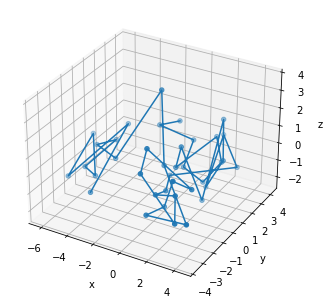

In [31]:
sdp('tiny_gph.dat', showplot=True)

CPLEX 20.1.0.0: optimal solution; objective 5931.370147
0 dual simplex iterations (0 in phase I)
19 barrier iterations
optimal obj. fun. value = 5931.37014674213
ambient dimension n = 38
found relaxed embedding in natural dimension K = 37
now projecting to 3 principal dimensions
DDP mean distance error = 1.8093311550580489
DDP largest distance error = 4.126467955100351
Cannot find "ipopt"
NLP mean distance error = 1.8093315550832791
NLP largest distance error = 4.126468374504312
OUTLABELS:mp,projmethod,objX,mdeX,ldeX,mdex,ldex
OUT:sdp,PCA,5931.370,1.809,4.126,1.809,4.126


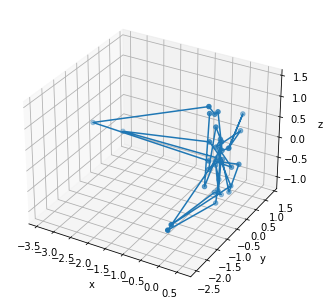

In [41]:
ddp('tiny_gph.dat', showplot=True)

#### old code

In [ ]:
N_printed_sents = 20
nlp = spacy.load('en_core_web_lg')

with open('train.txt') as f:
    train = np.array([float(line.strip()) for line in f])

for i, (s1, s2) in enumerate(sentences_test):
    v1 = np.mean(word_to_vec[s1,:], axis=0)
    v2 = np.mean(word_to_vec[s2,:], axis=0)
    d = (cosine_similarity([v1], [v2])[0,0]+1)/2.
    #print(d.shape)
    sent1, sent2 = lines_test[i].split('\t')
    sent1 = nlp(sent1)
    sent1 = nlp(' '.join([str(t) for t in sent1 if not t.is_stop]))
    sent2 = nlp(sent2)
    sent2 = nlp(' '.join([str(t) for t in sent2 if not t.is_stop]))
    #sent1 = nlp(' '.join([word for word in sent1 if word not in english_stopwords]))
    #sent2 = nlp(' '.join([word for word in sent2 if word not in english_stopwords]))
    similarity = sent1.similarity(sent2)
    #if similarity < 0.4:
    print(i, "{:1.8f} {:1.8f} {:1.8f}".format(train[i] / 5, d, similarity), lines_test[i], sep='\t')
    if i > N_printed_sents:
        break

0	0.48000000 0.92187823 0.92373690	A person is on a baseball team.	A person is playing basketball on a team.
1	0.04000000 0.35590817 0.63757388	Our current vehicles will be in museums when everyone has their own aircraft.	The car needs to some work
2	0.20000000 0.52993919 0.83476240	A woman supervisor is instructing the male workers.	A woman is working as a nurse.
3	0.40000000 0.97916754 0.81605440	A bike is next to a couple women.	A child next to a bike.
4	0.44000000 0.28898951 0.82062957	The group is eating while taking in a breathtaking view.	A group of people take a look at an unusual tree.
5	0.68000000 0.99434384 0.95368330	The boy is raising his hand.	The man is raising his hand.
6	0.16000000 0.69519802 0.81375333	A man with a gray beard is being shaved in front of a lecture hall	A man with a beard is sitting in the grass.
7	0.08000000 0.67610976 0.79174104	The sky has very little to no clouds.	This Lady might be ready for Rock Climbing, or just watching the Clouds, above.
8	0.08

In [ ]:
our_simlarity_n = 1-np.array([dist.cosine(np.mean(word_to_vec[s1,:], axis=0), np.mean(word_to_vec[s2,:], axis=0)) for (s1, s2) in sentences_test])/2
spacy_similarity_n = np.array([nlp(' '.join([str(t) for t in nlp(sent2) if not t.is_stop])).similarity(nlp(' '.join([str(t) for t in nlp(sent1) if not t.is_stop]))) for (sent1, sent2) in [s.split('\t') for s in lines_test]])
print(spacy_similarity_n[:10])

print(our_simlarity_n[:10])



[0.9237369  0.63757388 0.8347624  0.8160544  0.82062957 0.9536833
 0.81375333 0.79174104 0.82175876 1.        ]
[0.92187823 0.35590817 0.52993919 0.97916754 0.28898951 0.99434384
 0.69519802 0.67610976 0.51193864 0.98772491]


### 3.2 Pearson correlation coefficient
To estimate the quality of models we will use this coefficient, which is calculated as follows:
$$p_{XY} = \frac{\sigma_{XY}}{\sigma_X \cdot \sigma_Y}$$
where $p_{XY}$ is the Pearson correlation coefficient, $\sigma_Y, \sigma_X$ are standart deviations of $Y$ and $X$, and $\sigma_{XY}$ is the covariance between $X$ and $Y$ 


In [ ]:
#we normalize all the 
p_xy = np.corrcoef(train, spacy_similarity_n)
print("p_xy spacy train = ", p_xy[1, 0])
p_xy = np.corrcoef(our_simlarity_n, spacy_similarity_n)
print("p_xy spacy our_simlarity_n = ", p_xy[1, 0])
p_xy = np.corrcoef(train, our_simlarity_n)
print("p_xy our_simlarity_n train = ", p_xy[1, 0])


p_xy spacy train =  0.7131287525074835
p_xy spacy our_simlarity_n =  0.5395828515504087
p_xy our_simlarity_n train =  0.5113422409775331


In [ ]:
train_n = train/5  
spacy_similarity_scaled = (spacy_similarity_n-0.35)/0.65
print(np.mean(((spacy_similarity_scaled-train_n)**2)))

print(np.mean(((spacy_similarity_n-np.mean(spacy_similarity_n))**2)))
print(np.mean(spacy_similarity_n**2))

0.16965264574028385
0.007678251653702461
0.7751361274991766


In [ ]:
train_n = train/5  
spacy_similarity_scaled = (spacy_similarity_n-0.35)/0.65
print(np.mean(((spacy_similarity_scaled-train_n)**2)))

print(np.mean(((spacy_similarity_n-np.mean(spacy_similarity_n))**2)))
print(np.mean(spacy_similarity_n**2))

print('n')
print(np.mean(((our_simlarity_n**4-train_n)**2)))
print(np.mean(((spacy_similarity_n-train_n)**2)))
print(np.mean(((spacy_similarity_n**4-train_n)**2)))
print(np.mean(((spacy_similarity_n-our_simlarity_n)**2)))
t = np.mean(train_n)
print(np.mean(((train_n-t)**2)))

0.16965264574028385
0.007678251653702461
0.7751361274991766
n
0.10256349803064416
0.2299975111999682
0.06236852391124974
0.02809066985255107
0.08105832959999999


In [ ]:
 # _n for normalized
print(np.mean(((our_simlarity_n**4-train_n)**2)))
print(np.mean(((spacy_similarity_n-train_n)**2)))
print(np.mean(((spacy_similarity_n**4-train_n)**2)))
print(np.mean(((spacy_similarity_n-our_simlarity_n)**2)))
t = np.mean(train_n)
print(np.mean(((train_n-t)**2)))

0.10256349803064416
0.2299975111999682
0.06236852391124974
0.02809066985255107
0.08105832959999999
